<a href="https://colab.research.google.com/github/kjmobile/B735/blob/main/5_Netflix_Stock_RNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## RNN model to predict Netflix stock prices using 900 days of historical data.
- The dataset includes Open, High, Low, and Close prices for 900 days.
- A 30-day sliding window is used to create input sequences.
- 80% of the sequences (696 samples) are used for training, and 20% (174 samples) for testing.
- The model predicts the next day's Close price based on the previous 30 days, using Open, High, and Low prices as input features.
- Each training sample is generated using a **sliding window**: the model learns to map 30 consecutive days of (Open, High, Low) values to the Close price of the 31st day.

In [49]:
#num1.1 Import packages and load data
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, Subset
from torch.optim import Adam
import tqdm
from sklearn.metrics import mean_absolute_error, r2_score
import random
random.seed(42)
np.random.seed(42)
torch.manual_seed(42)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

In [50]:
# Read CSV file
data = pd.read_csv("https://raw.githubusercontent.com/kjmobile/data/refs/heads/main/ml/netflix.csv")

In [51]:
data.head(2)

,Date,Open,High,Low,Volume,Close
0,2015-12-16,120,123,118,13181000,123
1,2015-12-17,124,126,122,17284900,123


### Dataset Definition
We define a PyTorch Dataset that creates 30-day input sequences from Open, High, and Low prices.
The target label is the normalized Close price following each 30-day input window.


In [52]:
#num1.2 Define Dataset
class Netflix(Dataset):
    def __init__(self):
        self.csv = data
        self.data = self.csv.iloc[:, 1:4].values  # Open, High, Low
        self.data = self.data / np.max(self.data)  # normalize

        self.label = data["Close"].values
        self.label = self.label / np.max(self.label)

    def __len__(self):
        return len(self.data) - 30  # 30-day sequences

    def __getitem__(self, i):
        x = self.data[i:i+30]
        y = self.label[i+30]
        return x, y

### RNN Model Architecture
This model is built using PyTorch's `nn.RNN` module followed by two fully connected (dense) layers.  
The purpose of this architecture is to learn sequential patterns from stock price data over a 30-day window.

- **Input Shape**: Each sample is a sequence of 30 days × 3 features (Open, High, Low), so the input tensor has shape `(batch_size, 30, 3)`.

- **RNN Layer**:
  - `nn.RNN(input_size=3, hidden_size=8, num_layers=5, batch_first=True)`
  - This means:
    - Each day's input has 3 values.
    - The hidden state dimension is 8.
    - There are 5 stacked RNN layers.
    - `batch_first=True` means the input shape is `(batch, time, features)`.

- **Flatten Step**:
  - The RNN outputs a tensor of shape `(batch_size, 30, 8)`.
  - We flatten it to `(batch_size, 240)` using `torch.reshape`, because `30×8=240`.

- **Fully Connected Layers**:
  - First Dense Layer: `nn.Linear(240, 64)`  
    Reduces the 240-dimensional vector to a hidden representation of size 64.
  - Activation: `ReLU()` introduces non-linearity.
  - Second Dense Layer: `nn.Linear(64, 1)`  
    Outputs a single scalar prediction for the next day's **normalized Close price**.

- **Output**:  
  A 1D tensor of shape `(batch_size,)`, where each value is the predicted close price.

The model learns to map the sequential trend of Open/High/Low prices over 30 days to the following day’s closing price.


In [53]:
#num2.1 Define RNN Model
class RNN(nn.Module):
    def __init__(self):
        super(RNN, self).__init__()
        self.rnn = nn.RNN(input_size=3, hidden_size=8, num_layers=5, batch_first=True)
        self.fc1 = nn.Linear(240, 64)
        self.fc2 = nn.Linear(64, 1)
        self.relu = nn.ReLU()

    def forward(self, x, h0):
        x, _ = self.rnn(x, h0)
        x = torch.reshape(x, (x.shape[0], -1))
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        x = torch.flatten(x)
        return x

### Train-Test Split
The dataset is split in time: 80% for training and 20% for testing.
This ensures that future data is never used to predict the past.


In [54]:
#num2.2 Train/Test Split
dataset = Netflix()
split_index = int(len(dataset) * 0.8)
train_data = Subset(dataset, range(split_index))
test_data = Subset(dataset, range(split_index, len(dataset)))

train_loader = DataLoader(train_data, batch_size=32)
test_loader = DataLoader(test_data, batch_size=1)

In [55]:
#num3.1 Initialize Model and Optimizer
device = "cuda" if torch.cuda.is_available() else "cpu"
model = RNN().to(device)
optimizer = Adam(model.parameters(), lr=0.0001)
loss_fn = nn.MSELoss()

### Training Loop
We train the model over 200 epochs using the Adam optimizer and MSE loss.
Each training batch consists of 30-day sequences and their targets.


In [56]:
#num3.2 Train Loop
for epoch in range(200):
    model.train()
    iterator = tqdm.tqdm(train_loader, desc=f"Epoch {epoch}")
    for batch_x, batch_y in iterator:
        optimizer.zero_grad()
        h0 = torch.zeros(5, batch_x.shape[0], 8).to(device)
        pred = model(batch_x.float().to(device), h0)
        loss = loss_fn(pred, batch_y.float().to(device))
        loss.backward()
        optimizer.step()
        iterator.set_postfix(loss=loss.item())

Epoch 199: 100%|██████████| 24/24 [00:00<00:00, 31.89it/s, loss=0.00709]


In [57]:
# uncomment if you want to save the trained model
# torch.save(model.state_dict(), "rnn.pth")

# Model Evaluation

### Generate Predictions for Test Set

This cell generates predictions on the test set using the trained RNN model.  
Predicted and actual values are moved from GPU to CPU to allow NumPy conversion.  
The results are collected in lists and converted into NumPy arrays for evaluation.



In [61]:
preds_np = []
actuals_np = []

with torch.no_grad():
    for x_batch, y_batch in test_loader:
        x_batch = x_batch.to(torch.float32).to(device)
        y_batch = y_batch.to(torch.float32).to(device)

        h0 = torch.zeros(5, x_batch.size(0), 8).to(device)
        output = model(x_batch, h0)

        preds_np.append(output.cpu().numpy().flatten()[0])  # 또는 .item()
        actuals_np.append(y_batch.cpu().numpy().flatten()[0])

preds_np = np.array(preds_np)
actuals_np = np.array(actuals_np)



The model achieved a Test MSE of 0.0031, MAE of 0.0484, and MAPE of 6.33% on the test set.<br>
This indicates that the model predicts the next-day closing prices with relatively low error and approximately 6% average deviation from the actual values.

In [62]:
#num4.1 Evaluation on Test Set
from sklearn.metrics import mean_absolute_error, mean_squared_error

mae = mean_absolute_error(actuals_np, preds_np)
mse = mean_squared_error(actuals_np, preds_np)
mape = np.mean(np.abs((actuals_np - preds_np) / actuals_np)) * 100

print("Test MSE :", mse)
print("Test MAE :", mae)
print("Test MAPE: {:.2f}%".format(mape))

Test MSE : 0.0012751321773976088
Test MAE : 0.027149150148034096
Test MAPE: 3.49%


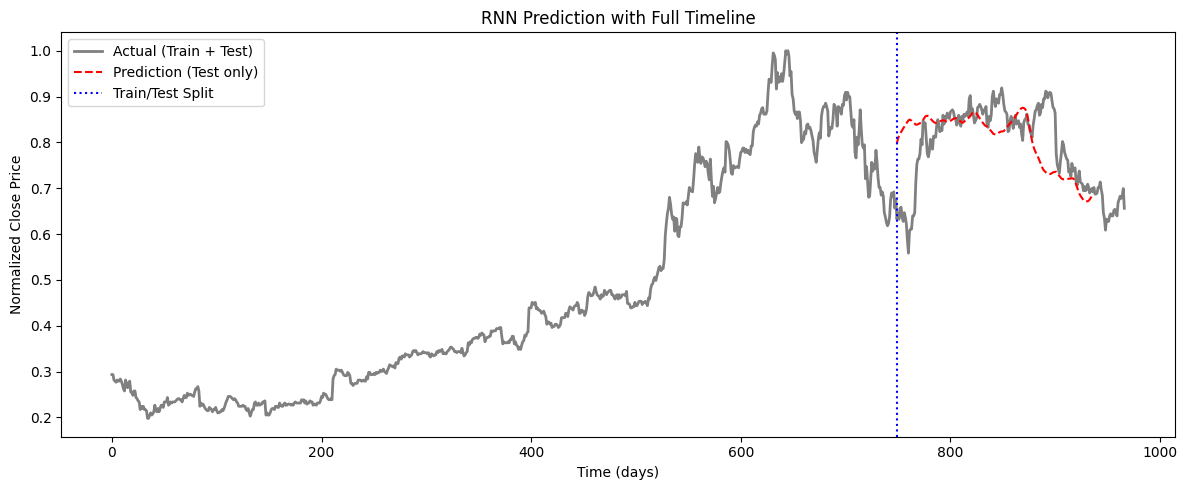

In [60]:
#num5.1 Plot Prediction vs Actual (Full Timeline with Train/Test Split)

# Full actual values
actual_full = dataset.label.tolist()

# Fill prediction list with NaNs for alignment
prediction_full = [np.nan] * split_index  # Skip training section
prediction_full += preds_np.tolist()      # Add test predictions

# Plot
plt.figure(figsize=(12, 5))
plt.plot(actual_full, label="Actual (Train + Test)", color="gray", linewidth=2)
plt.plot(prediction_full, label="Prediction (Test only)", color="red", linestyle="--")
plt.axvline(x=split_index, color="blue", linestyle=":", label="Train/Test Split")
plt.title("RNN Prediction with Full Timeline")
plt.xlabel("Time (days)")
plt.ylabel("Normalized Close Price")
plt.legend()
plt.tight_layout()
plt.show()
